In [ ]:
!pip install torchmetrics
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!git clone https://github.com/jalpv1//wiki-art-selected-resized-downsampled
!rm -rf .//wiki-art-selected-resized-downsampled/.git
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names = ['Abstract_Expressionism','Baroque','Cubism', 'Fauvism', 'Impressionism','Minimalism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']
device = 'cuda'
!pip install torchsampler
class ArtStyleDataset(Dataset):
  def __init__(self, root_dir, transform = None, transform_tensor = None):
     self.imgs = ImageFolder(root_dir)
     self.root_dir = root_dir
     self.transform = transform
     self.transform_tensor = transform_tensor


  def __len__(self):
        return len(self.imgs)

  def __getitem__(self, idx):
        sample, label = self.imgs[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

transform = transforms.Compose([
    transforms.Resize((229, 229)),
    transforms.ToTensor(),
])
#load data
data = ArtStyleDataset('wiki-art-selected-resized-downsampled', transform)

from torch.utils.data import Dataset, DataLoader, random_split
train_size = int(0.8 * len(data))
test_size = int(0.2 * len(data))
#val_size = len(data) - train_size - test_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=4)
#val_loader = DataLoader(val_dataset, shuffle=False, num_workers=4)

from torch.utils.data import WeightedRandomSampler

def extract_labels():
  features = []
  labels_ = []
  map_img_feature = {}
  for inputs, labels in train_loader:
      labels_.append(labels.numpy())
  return labels_
y = extract_labels()
y = np.concatenate(y)
unique, counts = np.unique(y, return_counts=True)


#Up sampling
class_weights = [1.0/c for c in counts]
sample_weights = [class_weights[i] for i in y]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset,sampler=sampler, batch_size = 32)
dataset_sizes= {"train" : len(train_loader), "test" : len(test_loader)}



fatal: destination path 'wiki-art-selected-resized-downsampled' already exists and is not an empty directory.
Python 3.11.11
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [ ]:
import torchmetrics
import pytorch_lightning as pl

num_classes = 10

In [ ]:
  #       a = nn.Sequential(
  #                           nn.Linear(512, 10),
  #                           # nn.ReLU(),
  #                           # nn.Dropout(0.4),
  #                           # nn.Linear(2048, 1024),
  #                           # nn.ReLU(),
  #                           # nn.Dropout(0.4),
  #                           # nn.Linear(1024, 10)
  #                           )
  #      v = torch.nn.Sequential( torch.nn.Flatten(),
  #   # torch.nn.Linear(512, 256),  # Optional: You can add intermediate layers like this
  #   # torch.nn.ReLU(),
  # #  torch.nn.Dropout(0.2),      # Optional: Dropout for regularization
  #     torch.nn.Linear(512, 10),   # Final layer with 10 outputs (for 10 classes)
  #       torch.nn.LogSoftmax(dim=1)  # LogSoftmax for classification
  #     )

In [ ]:
f1_res18= []
accuracy_res18 = []
recall_res18 =[]
precision_res18 = []

class Res18(pl.LightningModule):
    def __init__(self, num_classes):
        super(Res18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.validation_step_outputs = []
        self.train_step_outputs = []

        for param in self.model.parameters():
            param.requires_grad = False



        self.model.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_val = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_train = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.precision_val = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='weighted')
        self.recall_val = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='weighted')


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.accuracy.update(preds, y)
        self.f1_train.update(preds, y)

        self.train_step_outputs.append(loss)


        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        val_loss = nn.CrossEntropyLoss()(logits, y)

        preds = torch.argmax(logits, dim=1)

        self.val_accuracy(preds, y)
        self.f1_val(preds, y)
        self.precision_val(preds, y)
        self.recall_val(preds, y)


        self.val_accuracy.update(preds, y)
        self.f1_val.update(preds, y)
        self.precision_val.update(preds, y)
        self.recall_val.update(preds, y)



        self.validation_step_outputs.append(val_loss)



    def on_train_epoch_end(self):
        train_acc = self.accuracy.compute()
        epoch_f1_train = self.f1_train.compute()
        print(f"Epoch {self.current_epoch}: Train Accuracy: {train_acc:.4f} F1: {epoch_f1_train:.4f}")
        self.accuracy.reset()
        self.f1_train.reset()

    def on_validation_epoch_end(self):
        epoch_val_acc = self.val_accuracy.compute()
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        epoch_f1_val = self.f1_val.compute()
        epoch_precision_val = self.precision_val.compute()
        epoch_recall_val = self.recall_val.compute()

        print(f"Epoch {self.current_epoch}: Validation Accuracy: {epoch_val_acc:.4f} F1: {epoch_f1_val:.4f}  Recall: {epoch_recall_val:.4f}  Precision: {epoch_precision_val:.4f}")
        self.log("validation_epoch_accuracy", epoch_val_acc)
        self.log("validation_epoch_loss", avg_val_loss)
        self.log("f1_val", epoch_f1_val)

        f1_res18.append(epoch_f1_val.cpu().numpy())
        accuracy_res18.append(epoch_val_acc.cpu().numpy())
        recall_res18.append(epoch_recall_val.cpu().numpy())
        precision_res18.append(epoch_precision_val.cpu().numpy())

        self.val_accuracy.reset()
        self.f1_val.reset()
        self.precision_val.reset()
        self.recall_val.reset()


        self.validation_step_outputs.clear()




    def configure_optimizers(self):
        # Only optimize the final layer
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=0.0001)
        return optimizer


In [ ]:
import time

checkpoint_callback18 = ModelCheckpoint(

     monitor='f1_val',
       mode='max',
     dirpath='my/path2/',
     filename='2resnet18-{epoch:02d}-{f1_val:.2f}'
)

trainer18 = pl.Trainer(
    max_epochs=25,
   accelerator="cuda",
    callbacks =checkpoint_callback18
)

modelRes18 = Res18(num_classes=num_classes)

start_time = time.time()  # Record start time

trainer18.fit(modelRes18, train_loader, test_loader, ckpt_path=None)
end_time = time.time()  # Record end time

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/my/path2 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | ResNet              | 11.3 M | train
1 | accuracy      | MulticlassAccuracy  | 0      | train
2 | val_accuracy  | MulticlassAccuracy  | 0      | train
3 | f1_val        | MulticlassF1Score   | 0      | train
4 | f1_train      | MulticlassF1Score   | 0      | train
5 | precision_val | MulticlassPrecision | 0      | train
6 | r

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.0000 F1: 0.0000  Recall: 0.0000  Precision: 0.0000


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.5442 F1: 0.5171  Recall: 0.5442  Precision: 0.5964
Epoch 0: Train Accuracy: 0.3902 F1: 0.3602


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Accuracy: 0.6193 F1: 0.6057  Recall: 0.6193  Precision: 0.6277
Epoch 1: Train Accuracy: 0.5431 F1: 0.5259


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Accuracy: 0.6396 F1: 0.6251  Recall: 0.6396  Precision: 0.6484
Epoch 2: Train Accuracy: 0.5947 F1: 0.5858


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Accuracy: 0.6623 F1: 0.6586  Recall: 0.6623  Precision: 0.6657
Epoch 3: Train Accuracy: 0.6071 F1: 0.6002


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Validation Accuracy: 0.6822 F1: 0.6805  Recall: 0.6822  Precision: 0.6827
Epoch 4: Train Accuracy: 0.6306 F1: 0.6260


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Validation Accuracy: 0.6855 F1: 0.6822  Recall: 0.6855  Precision: 0.6874
Epoch 5: Train Accuracy: 0.6473 F1: 0.6430


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Validation Accuracy: 0.6890 F1: 0.6861  Recall: 0.6890  Precision: 0.6916
Epoch 6: Train Accuracy: 0.6581 F1: 0.6534


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Validation Accuracy: 0.6939 F1: 0.6884  Recall: 0.6939  Precision: 0.6909
Epoch 7: Train Accuracy: 0.6609 F1: 0.6565


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Validation Accuracy: 0.6966 F1: 0.6910  Recall: 0.6966  Precision: 0.6957
Epoch 8: Train Accuracy: 0.6702 F1: 0.6669


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: Validation Accuracy: 0.7039 F1: 0.7023  Recall: 0.7039  Precision: 0.7037
Epoch 9: Train Accuracy: 0.6790 F1: 0.6760


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: Validation Accuracy: 0.7004 F1: 0.6932  Recall: 0.7004  Precision: 0.7041
Epoch 10: Train Accuracy: 0.6820 F1: 0.6790


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: Validation Accuracy: 0.7090 F1: 0.7053  Recall: 0.7090  Precision: 0.7093
Epoch 11: Train Accuracy: 0.6858 F1: 0.6828


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: Validation Accuracy: 0.7101 F1: 0.7056  Recall: 0.7101  Precision: 0.7076
Epoch 12: Train Accuracy: 0.6943 F1: 0.6914


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: Validation Accuracy: 0.7190 F1: 0.7162  Recall: 0.7190  Precision: 0.7187
Epoch 13: Train Accuracy: 0.6927 F1: 0.6901


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: Validation Accuracy: 0.7117 F1: 0.7092  Recall: 0.7117  Precision: 0.7105
Epoch 14: Train Accuracy: 0.7010 F1: 0.6985


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: Validation Accuracy: 0.7182 F1: 0.7135  Recall: 0.7182  Precision: 0.7210
Epoch 15: Train Accuracy: 0.7030 F1: 0.7007


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: Validation Accuracy: 0.7203 F1: 0.7184  Recall: 0.7203  Precision: 0.7201
Epoch 16: Train Accuracy: 0.7101 F1: 0.7077


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: Validation Accuracy: 0.7182 F1: 0.7159  Recall: 0.7182  Precision: 0.7194
Epoch 17: Train Accuracy: 0.7049 F1: 0.7033


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: Validation Accuracy: 0.7193 F1: 0.7172  Recall: 0.7193  Precision: 0.7195
Epoch 18: Train Accuracy: 0.7075 F1: 0.7059


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: Validation Accuracy: 0.7168 F1: 0.7147  Recall: 0.7168  Precision: 0.7176
Epoch 19: Train Accuracy: 0.7191 F1: 0.7170


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: Validation Accuracy: 0.7241 F1: 0.7226  Recall: 0.7241  Precision: 0.7232
Epoch 20: Train Accuracy: 0.7183 F1: 0.7161


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: Validation Accuracy: 0.7271 F1: 0.7249  Recall: 0.7271  Precision: 0.7284
Epoch 21: Train Accuracy: 0.7249 F1: 0.7236


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: Validation Accuracy: 0.7266 F1: 0.7240  Recall: 0.7266  Precision: 0.7255
Epoch 22: Train Accuracy: 0.7218 F1: 0.7205


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: Validation Accuracy: 0.7271 F1: 0.7270  Recall: 0.7271  Precision: 0.7296
Epoch 23: Train Accuracy: 0.7202 F1: 0.7184


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: Validation Accuracy: 0.7282 F1: 0.7255  Recall: 0.7282  Precision: 0.7286
Epoch 24: Train Accuracy: 0.7348 F1: 0.7330
Training time: 3782.82 seconds


In [ ]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.5 MB/s eta 0:00:00a 0:00:01


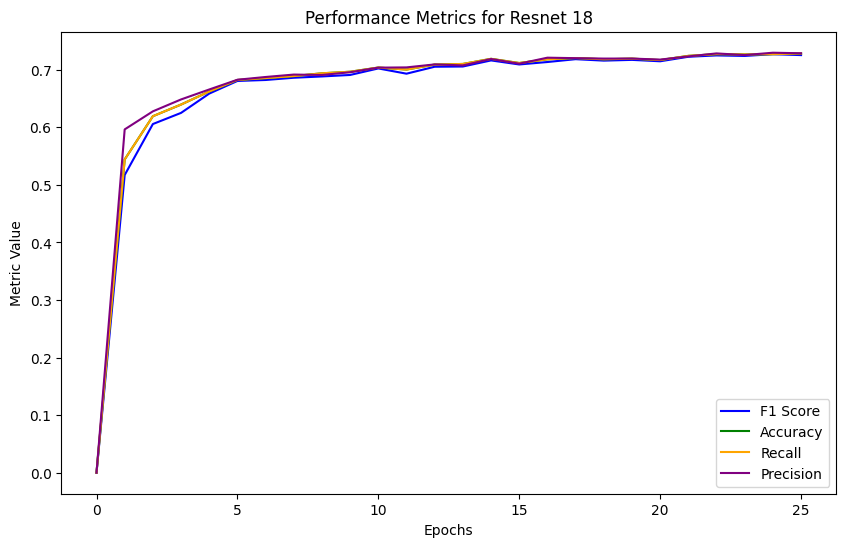

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
x_values = range(len(f1_res18))

plt.figure(figsize=(10, 6))

sns.lineplot(x=x_values, y= [float(item) for item in f1_res18], label="F1 Score", color="blue")
sns.lineplot(x=x_values, y=[float(item) for item in accuracy_res18], label="Accuracy", color="green")
sns.lineplot(x=x_values, y= [float(item) for item in recall_res18], label="Recall", color="orange")
sns.lineplot(x=x_values, y=[float(item) for item in precision_res18], label="Precision", color="purple")

plt.title("Performance Metrics for Resnet 18")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")

plt.legend()
plt.show()

In [ ]:
def evaluate_model(predicted, true):
  from sklearn.metrics import classification_report
  import pandas as pd
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  import matplotlib.pyplot as plt
  report_dict = classification_report(predicted, true, target_names=class_names, output_dict=True)
  metrics_df2 = pd.DataFrame(report_dict).transpose()
  print(metrics_df2)
  print("-----------------------------------------------------------------------------------------------------------")
  cm = confusion_matrix(true, predicted)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  fig, ax = plt.subplots(figsize=(8, 6))
  disp.plot(cmap="cividis", ax=ax, values_format="d")
  for _, spine in ax.spines.items():
        spine.set_visible(False)
  plt.xticks(rotation=90, ha="right")
  plt.yticks(rotation=0)
  plt.grid(False)
  plt.title("Confusion Matrix")
  plt.show()

def validate_model(model, data_loader):
    pred = []
    true = []
    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.extend(labels.cpu().numpy())
            pred.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total  # Calculate accuracy based on predictions

        print('Finished Testing')
        print(f'Testing accuracy: {accuracy:.1f} %')

    evaluate_model(pred, true)

Resbet 30

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
from torchvision import models

# Initialize metrics storage lists
f1_resnet30 = []
accuracy_resnet30 = []
recall_resnet30 = []
precision_resnet30 = []

class ResNet30(pl.LightningModule):
    def __init__(self, num_classes):
        super(ResNet30, self).__init__()
        # Load ResNet34 and modify it to mimic ResNet30 if needed
        self.model = models.resnet34(pretrained=True)
        self.validation_step_outputs = []
        self.train_step_outputs = []

        # Freeze pre-trained layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the classifier (fully connected layers)
        self.model.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

        # Define metrics
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_val = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_train = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.precision_val = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='weighted')
        self.recall_val = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='weighted')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.accuracy.update(preds, y)
        self.f1_train.update(preds, y)

        self.train_step_outputs.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        val_loss = nn.CrossEntropyLoss()(logits, y)

        preds = torch.argmax(logits, dim=1)

        self.val_accuracy(preds, y)
        self.f1_val(preds, y)
        self.precision_val(preds, y)
        self.recall_val(preds, y)

        self.val_accuracy.update(preds, y)
        self.f1_val.update(preds, y)
        self.precision_val.update(preds, y)
        self.recall_val.update(preds, y)

        self.validation_step_outputs.append(val_loss)

    def on_train_epoch_end(self):
        train_acc = self.accuracy.compute()
        epoch_f1_train = self.f1_train.compute()
        print(f"Epoch {self.current_epoch}: Train Accuracy: {train_acc:.4f} F1: {epoch_f1_train:.4f}")
        self.accuracy.reset()
        self.f1_train.reset()

    def on_validation_epoch_end(self):
        epoch_val_acc = self.val_accuracy.compute()
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        epoch_f1_val = self.f1_val.compute()
        epoch_precision_val = self.precision_val.compute()
        epoch_recall_val = self.recall_val.compute()

        print(f"Epoch {self.current_epoch}: Validation Accuracy: {epoch_val_acc:.4f} F1: {epoch_f1_val:.4f}  Recall: {epoch_recall_val:.4f}  Precision: {epoch_precision_val:.4f}")
        self.log("validation_epoch_accuracy", epoch_val_acc)
        self.log("validation_epoch_loss", avg_val_loss)
        self.log("f1_val", epoch_f1_val)

        f1_resnet30.append(epoch_f1_val.cpu().numpy())
        accuracy_resnet30.append(epoch_val_acc.cpu().numpy())
        recall_resnet30.append(epoch_recall_val.cpu().numpy())
        precision_resnet30.append(epoch_precision_val.cpu().numpy())

        self.val_accuracy.reset()
        self.f1_val.reset()
        self.precision_val.reset()
        self.recall_val.reset()

        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        # Optimize only the new fully connected layers
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=0.0001)
        return optimizer


In [ ]:
checkpoint_callback30 = ModelCheckpoint(

     monitor='f1_val',
       mode='max',
     dirpath='my/path2/',
     filename='resnet30-{epoch:02d}-{f1_val:.2f}'
)

trainer30 = pl.Trainer(
    max_epochs=25,
   accelerator="cuda",
    callbacks =checkpoint_callback30
)

modelRes30 = ResNet30(num_classes=num_classes)

trainer30.fit(modelRes30, train_loader, test_loader, ckpt_path=None)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: Validation Accuracy: 0.0000 F1: 0.0000  Recall: 0.0000  Precision: 0.0000


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.5712 F1: 0.5457  Recall: 0.5712  Precision: 0.5724
Epoch 0: Train Accuracy: 0.3976 F1: 0.3698


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Accuracy: 0.6206 F1: 0.6074  Recall: 0.6206  Precision: 0.6373
Epoch 1: Train Accuracy: 0.5494 F1: 0.5332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Accuracy: 0.6479 F1: 0.6434  Recall: 0.6479  Precision: 0.6684
Epoch 2: Train Accuracy: 0.5986 F1: 0.5886


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Accuracy: 0.6752 F1: 0.6697  Recall: 0.6752  Precision: 0.6774
Epoch 3: Train Accuracy: 0.6186 F1: 0.6115


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Validation Accuracy: 0.6785 F1: 0.6735  Recall: 0.6785  Precision: 0.6803
Epoch 4: Train Accuracy: 0.6375 F1: 0.6331


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Validation Accuracy: 0.6809 F1: 0.6762  Recall: 0.6809  Precision: 0.6839
Epoch 5: Train Accuracy: 0.6512 F1: 0.6476


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Validation Accuracy: 0.6976 F1: 0.6931  Recall: 0.6976  Precision: 0.6963
Epoch 6: Train Accuracy: 0.6668 F1: 0.6641


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Validation Accuracy: 0.6976 F1: 0.6916  Recall: 0.6976  Precision: 0.6970
Epoch 7: Train Accuracy: 0.6773 F1: 0.6746


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Validation Accuracy: 0.6982 F1: 0.6950  Recall: 0.6982  Precision: 0.6981
Epoch 8: Train Accuracy: 0.6806 F1: 0.6788


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: Validation Accuracy: 0.6958 F1: 0.6928  Recall: 0.6958  Precision: 0.7020
Epoch 9: Train Accuracy: 0.6830 F1: 0.6807


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: Validation Accuracy: 0.7058 F1: 0.7029  Recall: 0.7058  Precision: 0.7065
Epoch 10: Train Accuracy: 0.6906 F1: 0.6884


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: Validation Accuracy: 0.7085 F1: 0.7060  Recall: 0.7085  Precision: 0.7110
Epoch 11: Train Accuracy: 0.6900 F1: 0.6881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: Validation Accuracy: 0.7082 F1: 0.7047  Recall: 0.7082  Precision: 0.7081
Epoch 12: Train Accuracy: 0.7051 F1: 0.7030


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: Validation Accuracy: 0.7066 F1: 0.7062  Recall: 0.7066  Precision: 0.7099
Epoch 13: Train Accuracy: 0.7057 F1: 0.7041


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: Validation Accuracy: 0.7144 F1: 0.7113  Recall: 0.7144  Precision: 0.7142
Epoch 14: Train Accuracy: 0.7118 F1: 0.7098


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: Validation Accuracy: 0.7152 F1: 0.7106  Recall: 0.7152  Precision: 0.7144
Epoch 15: Train Accuracy: 0.7091 F1: 0.7073


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: Validation Accuracy: 0.7120 F1: 0.7086  Recall: 0.7120  Precision: 0.7153
Epoch 16: Train Accuracy: 0.7137 F1: 0.7120


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: Validation Accuracy: 0.7187 F1: 0.7157  Recall: 0.7187  Precision: 0.7196
Epoch 17: Train Accuracy: 0.7203 F1: 0.7187


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: Validation Accuracy: 0.7185 F1: 0.7160  Recall: 0.7185  Precision: 0.7178
Epoch 18: Train Accuracy: 0.7285 F1: 0.7270


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: Validation Accuracy: 0.7230 F1: 0.7201  Recall: 0.7230  Precision: 0.7234
Epoch 19: Train Accuracy: 0.7264 F1: 0.7251


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: Validation Accuracy: 0.7190 F1: 0.7155  Recall: 0.7190  Precision: 0.7195
Epoch 20: Train Accuracy: 0.7315 F1: 0.7302


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: Validation Accuracy: 0.7233 F1: 0.7195  Recall: 0.7233  Precision: 0.7225
Epoch 21: Train Accuracy: 0.7347 F1: 0.7334


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: Validation Accuracy: 0.7222 F1: 0.7204  Recall: 0.7222  Precision: 0.7232
Epoch 22: Train Accuracy: 0.7358 F1: 0.7343


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: Validation Accuracy: 0.7257 F1: 0.7249  Recall: 0.7257  Precision: 0.7260
Epoch 23: Train Accuracy: 0.7398 F1: 0.7388


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: Validation Accuracy: 0.7247 F1: 0.7228  Recall: 0.7247  Precision: 0.7275
Epoch 24: Train Accuracy: 0.7418 F1: 0.7405


In [ ]:
!pip install seaborn

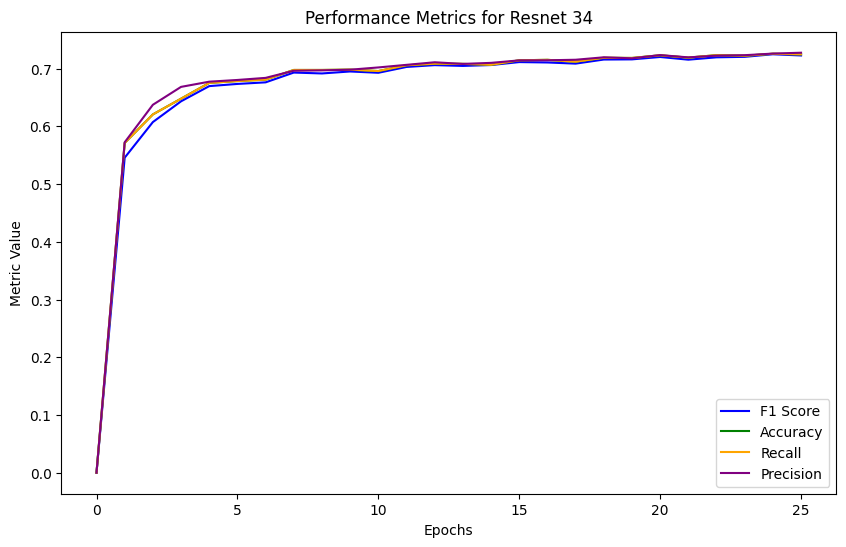

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
x_values = range(len(f1_resnet30))

plt.figure(figsize=(10, 6))

sns.lineplot(x=x_values, y= [float(item) for item in f1_resnet30], label="F1 Score", color="blue")
sns.lineplot(x=x_values, y=[float(item) for item in accuracy_resnet30], label="Accuracy", color="green")
sns.lineplot(x=x_values, y= [float(item) for item in recall_resnet30], label="Recall", color="orange")
sns.lineplot(x=x_values, y=[float(item) for item in precision_resnet30], label="Precision", color="purple")

plt.title("Performance Metrics for Resnet 34")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")

plt.legend()
plt.show()

In [ ]:
Resnet50

Resnet50

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
from torchvision import models

# Initialize metrics storage lists
f1_resnet50 = []
accuracy_resnet50 = []
recall_resnet50 = []
precision_resnet50 = []

class ResNet50(pl.LightningModule):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        # Load ResNet34 and modify it to mimic ResNet30 if needed
        self.model = models.resnet50(pretrained=True)
        self.validation_step_outputs = []
        self.train_step_outputs = []

        # Freeze pre-trained layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the classifier (fully connected layers)
        self.model.fc = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

        # Define metrics
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_val = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_train = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.precision_val = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='weighted')
        self.recall_val = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='weighted')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.accuracy.update(preds, y)
        self.f1_train.update(preds, y)

        self.train_step_outputs.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        val_loss = nn.CrossEntropyLoss()(logits, y)

        preds = torch.argmax(logits, dim=1)

        self.val_accuracy(preds, y)
        self.f1_val(preds, y)
        self.precision_val(preds, y)
        self.recall_val(preds, y)

        self.val_accuracy.update(preds, y)
        self.f1_val.update(preds, y)
        self.precision_val.update(preds, y)
        self.recall_val.update(preds, y)

        self.validation_step_outputs.append(val_loss)

    def on_train_epoch_end(self):
        train_acc = self.accuracy.compute()
        epoch_f1_train = self.f1_train.compute()
        print(f"Epoch {self.current_epoch}: Train Accuracy: {train_acc:.4f} F1: {epoch_f1_train:.4f}")
        self.accuracy.reset()
        self.f1_train.reset()

    def on_validation_epoch_end(self):
        epoch_val_acc = self.val_accuracy.compute()
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        epoch_f1_val = self.f1_val.compute()
        epoch_precision_val = self.precision_val.compute()
        epoch_recall_val = self.recall_val.compute()

        print(f"Epoch {self.current_epoch}: Validation Accuracy: {epoch_val_acc:.4f} F1: {epoch_f1_val:.4f}  Recall: {epoch_recall_val:.4f}  Precision: {epoch_precision_val:.4f}")
        self.log("validation_epoch_accuracy", epoch_val_acc)
        self.log("validation_epoch_loss", avg_val_loss)
        self.log("f1_val", epoch_f1_val)

        f1_resnet50.append(epoch_f1_val.cpu().numpy())
        accuracy_resnet50.append(epoch_val_acc.cpu().numpy())
        recall_resnet50.append(epoch_recall_val.cpu().numpy())
        precision_resnet50.append(epoch_precision_val.cpu().numpy())

        self.val_accuracy.reset()
        self.f1_val.reset()
        self.precision_val.reset()
        self.recall_val.reset()

        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        # Optimize only the new fully connected layers
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=0.0001)
        return optimizer


In [ ]:
checkpoint_callback50 = ModelCheckpoint(

     monitor='f1_val',
       mode='max',
     dirpath='my/path2/',
     filename='resnet50-{epoch:02d}-{f1_val:.2f}'
)

trainer50 = pl.Trainer(
    max_epochs=25,
   accelerator="cuda",
    callbacks =checkpoint_callback50
)
print("helooooooooooo")
modelRes50 = ResNet50(num_classes=10)

trainer50.fit(modelRes50, train_loader, test_loader, ckpt_path=None)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


helooooooooooo


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  3%|▎         | 2.75M/97.8M [00:00<00:03, 28.6MB/s]

  8%|▊         | 8.12M/97.8M [00:00<00:02, 43.9MB/s]

 14%|█▍        | 13.9M/97.8M [00:00<00:01, 50.5MB/s]

 21%|██        | 20.1M/97.8M [00:00<00:01, 56.1MB/s]

 26%|██▌       | 25.5M/97.8M [00:00<00:01, 49.2MB/s]

 32%|███▏      | 31.2M/97.8M [00:00<00:01, 52.5MB/s]

 38%|███▊      | 37.1M/97.8M [00:00<00:01, 55.2MB/s]

 44%|████▍     | 43.1M/97.8M [00:00<00:01, 57.1MB/s]

 55%|█████▌    | 53.9M/97.8M [00:00<00:00, 72.5MB/s]

 66%|██████▌   | 64.8M/97.8M [00:01<00:00, 84.3MB/s]

 75%|███████▍  | 72.9M/97.8M [00:01<00:00, 73.6MB/s]

 82%|████████▏ | 80.2M/97.8M [00:01<00:00, 63.3MB/s]

 89%|████████▊ | 86.8M/97.8M [00:01<00:00, 58.6MB/s]

100%|██████████| 97.8M/97.8M [00:01<00:00, 58.7MB/s]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbac

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: Validation Accuracy: 0.0000 F1: 0.0000  Recall: 0.0000  Precision: 0.0000


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.6296 F1: 0.6090  Recall: 0.6296  Precision: 0.6652
Epoch 0: Train Accuracy: 0.4668 F1: 0.4417


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Accuracy: 0.6790 F1: 0.6728  Recall: 0.6790  Precision: 0.6902
Epoch 1: Train Accuracy: 0.6022 F1: 0.5895


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Accuracy: 0.6939 F1: 0.6897  Recall: 0.6939  Precision: 0.6974
Epoch 2: Train Accuracy: 0.6386 F1: 0.6313


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Accuracy: 0.6990 F1: 0.6955  Recall: 0.6990  Precision: 0.7077
Epoch 3: Train Accuracy: 0.6559 F1: 0.6509


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Validation Accuracy: 0.7093 F1: 0.7065  Recall: 0.7093  Precision: 0.7144
Epoch 4: Train Accuracy: 0.6706 F1: 0.6663


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Validation Accuracy: 0.7131 F1: 0.7099  Recall: 0.7131  Precision: 0.7168
Epoch 5: Train Accuracy: 0.6812 F1: 0.6786


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Validation Accuracy: 0.7166 F1: 0.7134  Recall: 0.7166  Precision: 0.7185
Epoch 6: Train Accuracy: 0.6878 F1: 0.6855


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Validation Accuracy: 0.7195 F1: 0.7159  Recall: 0.7195  Precision: 0.7203
Epoch 7: Train Accuracy: 0.6993 F1: 0.6964


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Validation Accuracy: 0.7249 F1: 0.7251  Recall: 0.7249  Precision: 0.7292
Epoch 8: Train Accuracy: 0.7058 F1: 0.7031


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: Validation Accuracy: 0.7328 F1: 0.7315  Recall: 0.7328  Precision: 0.7321
Epoch 9: Train Accuracy: 0.7124 F1: 0.7103


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: Validation Accuracy: 0.7328 F1: 0.7294  Recall: 0.7328  Precision: 0.7355
Epoch 10: Train Accuracy: 0.7233 F1: 0.7216


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: Validation Accuracy: 0.7393 F1: 0.7371  Recall: 0.7393  Precision: 0.7382
Epoch 11: Train Accuracy: 0.7278 F1: 0.7260


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: Validation Accuracy: 0.7414 F1: 0.7415  Recall: 0.7414  Precision: 0.7436
Epoch 12: Train Accuracy: 0.7244 F1: 0.7226


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: Validation Accuracy: 0.7406 F1: 0.7385  Recall: 0.7406  Precision: 0.7393
Epoch 13: Train Accuracy: 0.7272 F1: 0.7254


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: Validation Accuracy: 0.7374 F1: 0.7353  Recall: 0.7374  Precision: 0.7408
Epoch 14: Train Accuracy: 0.7370 F1: 0.7358


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: Validation Accuracy: 0.7420 F1: 0.7417  Recall: 0.7420  Precision: 0.7443
Epoch 15: Train Accuracy: 0.7431 F1: 0.7416


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: Validation Accuracy: 0.7449 F1: 0.7447  Recall: 0.7449  Precision: 0.7454
Epoch 16: Train Accuracy: 0.7393 F1: 0.7377


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: Validation Accuracy: 0.7490 F1: 0.7470  Recall: 0.7490  Precision: 0.7475
Epoch 17: Train Accuracy: 0.7409 F1: 0.7398


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: Validation Accuracy: 0.7420 F1: 0.7389  Recall: 0.7420  Precision: 0.7467
Epoch 18: Train Accuracy: 0.7433 F1: 0.7419


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: Validation Accuracy: 0.7479 F1: 0.7474  Recall: 0.7479  Precision: 0.7495
Epoch 19: Train Accuracy: 0.7538 F1: 0.7524


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: Validation Accuracy: 0.7444 F1: 0.7429  Recall: 0.7444  Precision: 0.7438
Epoch 20: Train Accuracy: 0.7520 F1: 0.7507


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: Validation Accuracy: 0.7455 F1: 0.7438  Recall: 0.7455  Precision: 0.7446
Epoch 21: Train Accuracy: 0.7520 F1: 0.7509


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: Validation Accuracy: 0.7506 F1: 0.7505  Recall: 0.7506  Precision: 0.7516
Epoch 22: Train Accuracy: 0.7617 F1: 0.7609


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: Validation Accuracy: 0.7533 F1: 0.7520  Recall: 0.7533  Precision: 0.7527
Epoch 23: Train Accuracy: 0.7581 F1: 0.7570


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: Validation Accuracy: 0.7525 F1: 0.7506  Recall: 0.7525  Precision: 0.7535
Epoch 24: Train Accuracy: 0.7657 F1: 0.7645


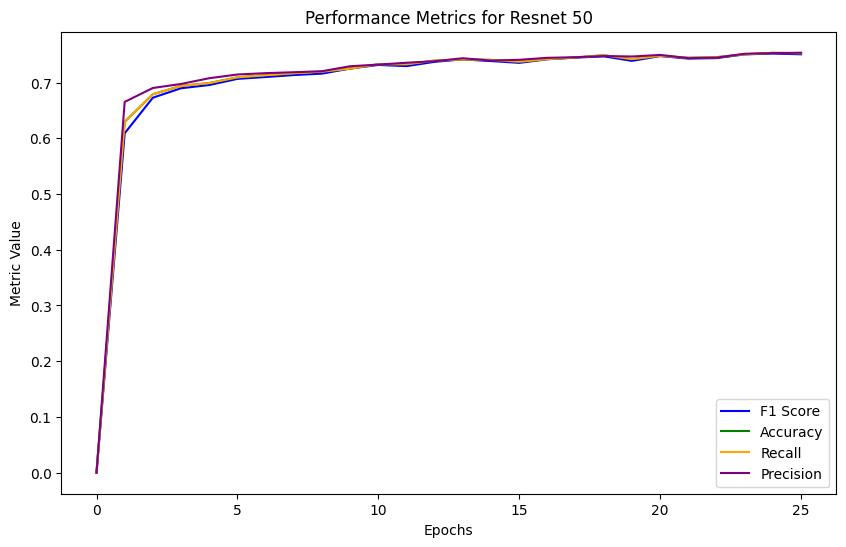

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
x_values = range(len(f1_resnet50))

plt.figure(figsize=(10, 6))

sns.lineplot(x=x_values, y= [float(item) for item in f1_resnet50], label="F1 Score", color="blue")
sns.lineplot(x=x_values, y=[float(item) for item in accuracy_resnet50], label="Accuracy", color="green")
sns.lineplot(x=x_values, y= [float(item) for item in recall_resnet50], label="Recall", color="orange")
sns.lineplot(x=x_values, y=[float(item) for item in precision_resnet50], label="Precision", color="purple")

plt.title("Performance Metrics for Resnet 50")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")

plt.legend()
plt.show()

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finished Testing
Testing accuracy: 75.0 %
                        precision    recall  f1-score      support
Abstract_Expressionism   0.801444  0.742475  0.770833   299.000000
Baroque                  0.747253  0.728571  0.737794   280.000000
Cubism                   0.779343  0.798077  0.788599   208.000000
Fauvism                  0.450549  0.546667  0.493976    75.000000
Impressionism            0.849817  0.711656  0.774624   326.000000
Minimalism               0.836538  0.906250  0.870000    96.000000
Naive_Art_Primitivism    0.613821  0.774359  0.684807   195.000000
Pointillism              0.863636  0.826087  0.844444    69.000000
Rococo                   0.630435  0.651685  0.640884   178.000000
Ukiyo_e                  0.903226  0.896000  0.899598   125.000000
accuracy                 0.749865  0.749865  0.749865     0.749865
macro avg                0.747606  0.758183  0.750556  1851.000000
weighted avg             0.759866  0.749865  0.752305  1851.000000


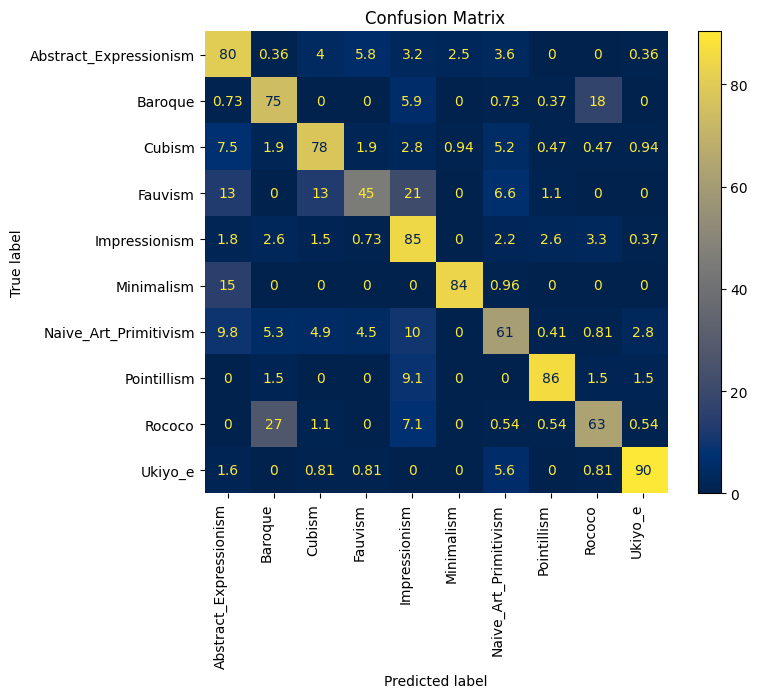

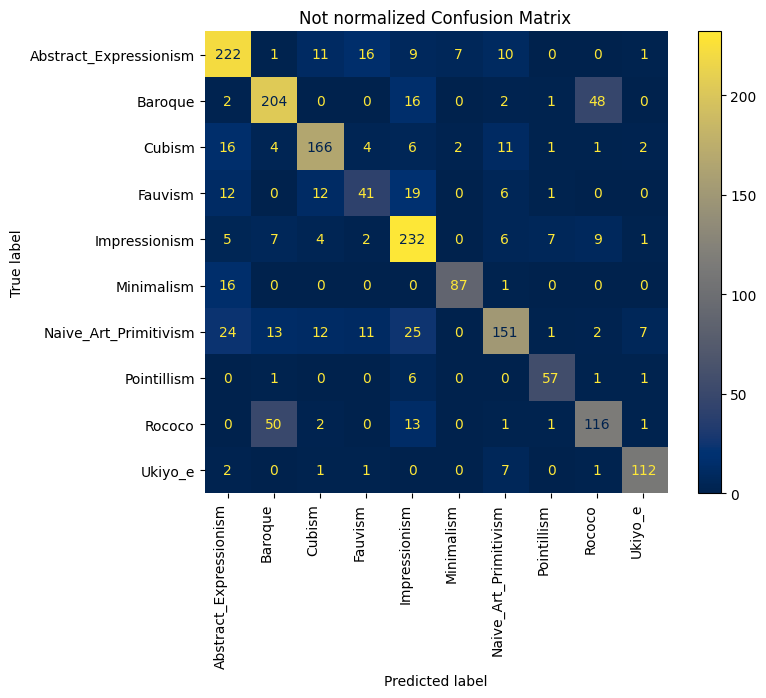

In [ ]:
model1 = ResNet50.load_from_checkpoint(checkpoint_path="my/path2/resnet50-epoch=24-f1_val=0.74.ckpt",  num_classes=10)
model1.to(device)
validate_model(model1, val_loader)

In [ ]:
from google.colab import files
files.download('/content/my/path/resnet50-epoch=14-f1_val=0.74.ckpt')

FileNotFoundError: Cannot find file: /content/my/path/resnet50-epoch=14-f1_val=0.74.ckpt

In [ ]:
from google.colab import files
files.download('/content/my/path/resnet30-epoch=14-f1_val=0.71.ckpt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def evaluate_model(predicted, true):
  from sklearn.metrics import classification_report
  import pandas as pd
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  import matplotlib.pyplot as plt
  report_dict = classification_report(predicted, true, target_names=class_names, output_dict=True)
  metrics_df2 = pd.DataFrame(report_dict).transpose()
  print(metrics_df2)

  disp = ConfusionMatrixDisplay(confusion_matrix(true, predicted, normalize = 'true' )*100, display_labels=class_names)

  fig, ax = plt.subplots(figsize=(8, 6))
  disp.plot(cmap="cividis", ax=ax)
  for _, spine in ax.spines.items():
      spine.set_visible(False)
  plt.xticks(rotation=90, ha="right")
  plt.yticks(rotation=0)
  plt.grid(False)
  plt.title("Confusion Matrix")
    #plt.colorbar(ax.collections[0], ax=ax)
  disp = ConfusionMatrixDisplay(confusion_matrix(true, predicted), display_labels=class_names)

  fig, ax = plt.subplots(figsize=(8, 6))
  disp.plot(cmap="cividis", ax=ax)
  for _, spine in ax.spines.items():
        spine.set_visible(False)

  plt.xticks(rotation=90, ha="right")
  plt.yticks(rotation=0)
  plt.grid(False)
  plt.title("Not normalized Confusion Matrix")
  plt.show()


def validate_model(model, data_loader):
    pred = []
    true = []
    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.extend(labels.cpu().numpy())
            pred.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total  # Calculate accuracy based on predictions

        print('Finished Testing')
        print(f'Testing accuracy: {accuracy:.1f} %')

    evaluate_model(pred, true)